# Аналитика продаж компьютерных игр

## Описание проекта

<p>Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.</p>
<p>Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.</p>



<b>Цель:</b> Выявить параметры, которые определят успешность игр, для дальнейшего управления продуктами (определение перспективных сфер, распределение рекламных бюджетов, текущая / перспективная популярность).

<b>Выборка:</b> Исторические данные о выпущенных играх с продажами по регионам. Предположительно данные 2016 года - не полные.

<b>Шаг 1.</b> Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy import stats as st
import os

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('C:\\Users\\MAX\\Downloads\\games.csv')    

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
# проверка количества дубликатов в датасете
data.duplicated().sum()

0

In [6]:
#проверка кол-ва пропусков
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

<b>Шаг 2.</b> Подготовка данных

In [7]:
# Заменим названия столбцов (приведем к нижнему регистру)
data.columns = data.columns.str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [8]:
# выше мы определили 2 пропуска в столбце name, genre  - по 2
data[data['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [9]:
# 2 пропуска из множества тысячей строк можно удалить, так как они не влияют на общую картину
data = data.dropna(subset=['name'])

In [10]:
# пропусков year_of_release - 269
data[data['year_of_release'].isnull()].head()


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


In [11]:
# 269 пропусков из 16446 строк также является незначительной частью в процентном соотношении и можно удалить
data = data.dropna(subset = ['year_of_release'])
data['year_of_release'] = data['year_of_release'].astype(int)
data[data['year_of_release'].isnull()]


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [12]:
# посмотрим на пропуски в столбце rating
data[data['rating'].isnull()].head()
# В основном пропущены одновременно critic_score, user_score и rating 
# Пропусков очень много, удалять их не рекомендуется

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


In [13]:
# пропуски можно заменить на unknown
data['rating'] = data['rating'].fillna('unknown')
data['rating'].value_counts()

unknown    6676
E          3921
T          2905
M          1536
E10+       1393
EC            8
K-A           3
AO            1
RP            1
Name: rating, dtype: int64

In [14]:
# пропусков в critical_score очень много, посмотрим часть из них
data[data['critic_score'].isnull()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,unknown
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,unknown
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,unknown


In [15]:
# заменим пропуски на значения -8, чтобы они особо не исказили нам общую ситуацию и преобразуем к целочисленному типу
data['critic_score'] = data['critic_score'].fillna('-8').astype(int)
data['critic_score'].value_counts()

-8     8461
 70     252
 71     248
 75     240
 80     235
       ... 
 20       3
 29       3
 21       1
 17       1
 13       1
Name: critic_score, Length: 82, dtype: int64

In [16]:
# пропусков в user_score очень много, посмотрим часть из них
data[data['user_score'].isnull()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-8,NaN,unknown
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-8,NaN,unknown
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-8,NaN,unknown
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-8,NaN,unknown
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,-8,NaN,unknown


In [17]:
# Обратим внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберем это значение
data[data['user_score'] == 'tbd'].head()


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,-8,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,-8,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,-8,tbd,E


In [18]:
# посчитаем процент строк с "tbd" 
len(data[data['user_score'] == 'tbd']) / len(data) 


0.14449039163220628

Аббревиатура 'tbd' не отличается от пропусков и таких значений около 14,5%. можно заменить их таким же образом, как и пропуски в столбце critic_score

In [19]:
# также нужно поменять тип данных на числовой вещественный в этом столбце, потому что изначально он был объектный
data['user_score'] = data['user_score'].replace('tbd', -8).astype('float')
data['user_score'].unique()

array([ 8. ,  nan,  8.3,  8.5,  6.6,  8.4,  8.6,  7.7,  6.3,  7.4,  8.2,
        9. ,  7.9,  8.1,  8.7,  7.1,  3.4,  5.3,  4.8,  3.2,  8.9,  6.4,
        7.8,  7.5,  2.6,  7.2,  9.2,  7. ,  7.3,  4.3,  7.6,  5.7,  5. ,
        9.1,  6.5, -8. ,  8.8,  6.9,  9.4,  6.8,  6.1,  6.7,  5.4,  4. ,
        4.9,  4.5,  9.3,  6.2,  4.2,  6. ,  3.7,  4.1,  5.8,  5.6,  5.5,
        4.4,  4.6,  5.9,  3.9,  3.1,  2.9,  5.2,  3.3,  4.7,  5.1,  3.5,
        2.5,  1.9,  3. ,  2.7,  2.2,  2. ,  9.5,  2.1,  3.6,  2.8,  1.8,
        3.8,  0. ,  1.6,  9.6,  2.4,  1.7,  1.1,  0.3,  1.5,  0.7,  1.2,
        2.3,  0.5,  1.3,  0.2,  0.6,  1.4,  0.9,  1. ,  9.7])

In [20]:
# посмотрим на обработанные данные
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-8,NaN,unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-8,NaN,unknown


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int32  
 9   user_score       9839 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(5), int32(2), object(4)
memory usage: 1.4+ MB


In [22]:
# посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-8,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-8,NaN,unknown,31.38


<b>Итог по предподготовке данных:</b> 
    Получилось преобразовать данные в датасете для дальнейшего использования - проработали пропуски:  в каких-то случаях строки были удалены за ненадобностью, в других пропуски - заменены на значение -8

Настало время прояснить, что рейтинг ESRB - это рейтинг для США и Канады. Значит пропуски не савязаны с ошибкой заполнения данных, просто не только для Северной Америки выпускаются игры

In [23]:
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int32  
 9   user_score       9839 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(6), int32(2), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

<b>Шаг 3.</b> Проведем исследовательский анализ данных

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. 

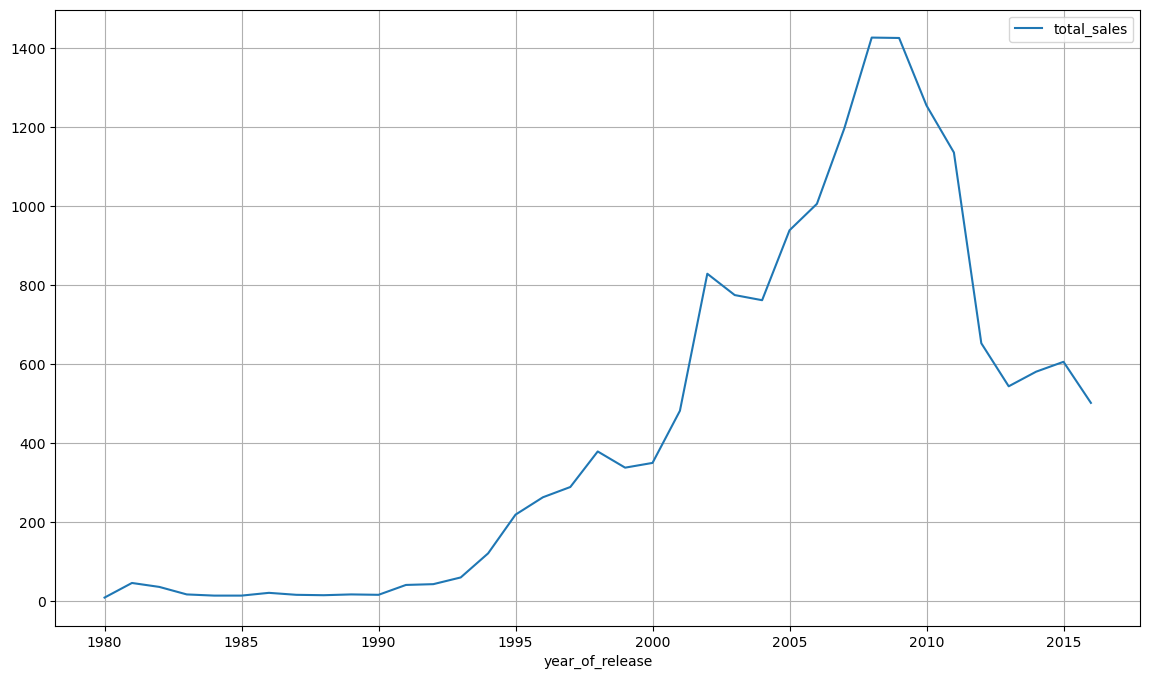

In [24]:
# сначала посмотрим зависимости количества игр от года выпуска
platform_sales = data.pivot_table(index='year_of_release', values='total_sales', aggfunc='count').plot(grid=True, figsize=(14, 8))

   Из графика можно увидеть, что начиная с 1995 года начался рост количества игр, с 1998 по 2000 выявлен некий "застой", а далее идет резкий подъем до 2008-2009г, где достигается пик количества игр, затем наступил спад -  до самого 2016г. Следовательно, более показательными для анализа будут последние 10 лет - на них и будем обращать основное внимание

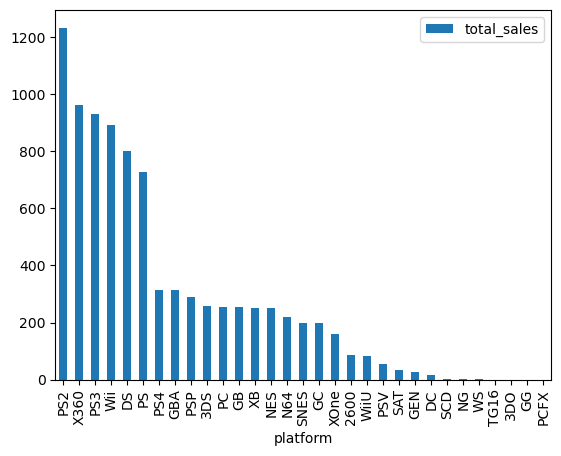

In [25]:
# здесь рассмотрим конкретно зависимости продаж по платформам
platform_sales = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values('total_sales', ascending=False).plot(kind='bar')

    Из этого графика можно увидеть платформы с наибольшими суммарными продажами: PS2, X360, PS3, Wii, DS, PS. Эти 6 платформ очевидно имеют высокие продажи относительно всех остальных

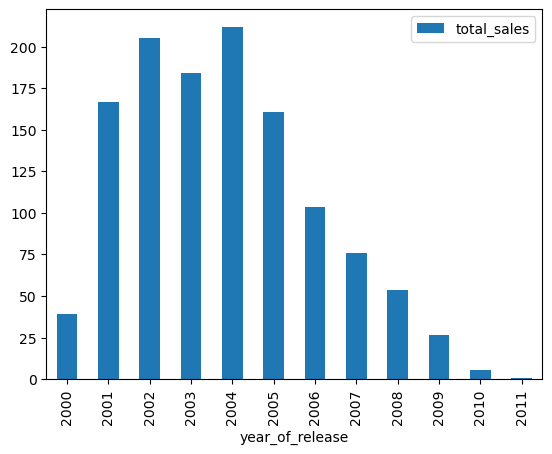

In [26]:
# Рассмотрим каждую платформу по отдельности, сделав сводные таблицы с графиками
data.query('platform == "PS2"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar');


По этой платформе PS2 видно, что она была очень популярна в период 2001-2005гг., но далее начался спад и к 2011 продажи прекратились, сейчас платформа не актуальна 

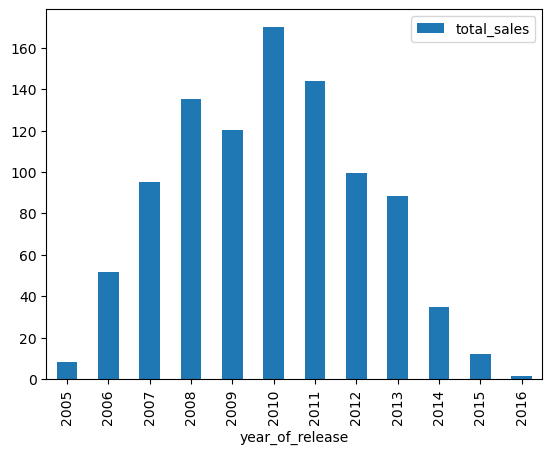

In [27]:
# проделаем тоже самое с платформой X360
data.query('platform == "X360"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar');

По этой платформе можно увидеть примерно туже картину, но с некоторыми особенностями: пик с 2008-2012 и далее такой же стремительный спад и к 2016 эта платформа практически неактуальна

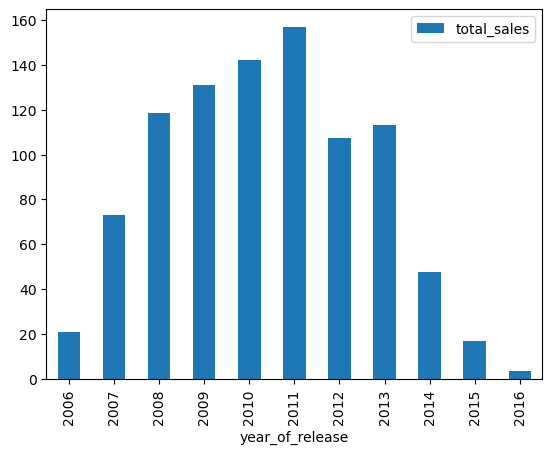

In [28]:
data.query('platform == "PS3"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar');

Аналогично и по этой платформе: пик - 2008-2013 и далее стремительный спад и к 2016 эта платформа практически неактуальна

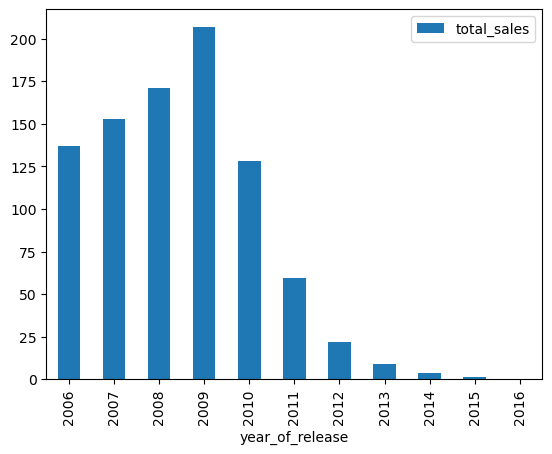

In [29]:
data.query('platform == "Wii"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar');

По этому графику видно, что сразу на релизе 2006 года были высокие продажи и далее пик сохранялся вплоть по 2010. С 2011 пошел спад и к 2016г эта платформа практически неактуальна

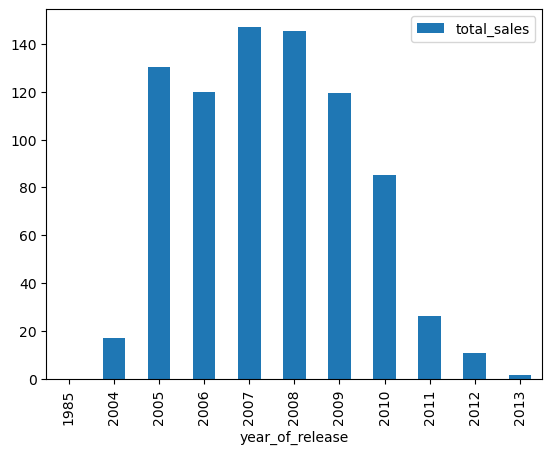

In [30]:
data.query('platform == "DS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar');

По платформе DS можно сказать, что продажи начались в 2004 и быстро достигли своего максимума уже в 2007 - весь пиковый период соствил 6 лет(2005-2010), затем следует спад и к 2013г эта платформа практически неактуальна. Также мы обнаружили ошибку, так как в 1985 году этой платформы еще не существовало.

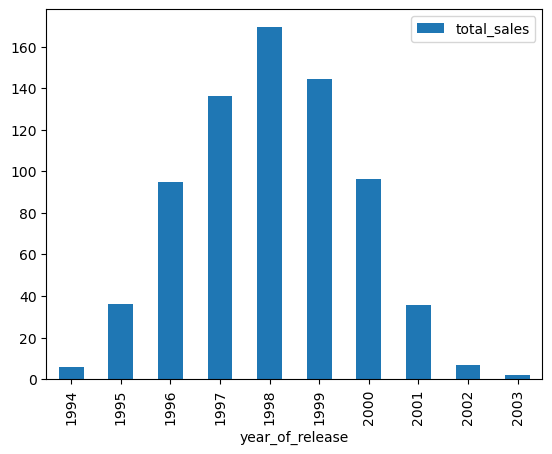

In [31]:
data.query('platform == "PS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar');

Рассматривая график, сразу бросается в глаза, что это самая старая платформа с пиковым периодом продаж 1996-2000, далее виден очевидный спад и уже к 2003 платформа неактуальна

По итогу вырисовывается актуальный период - около 3 лет до 2017 - его следует брать для формирования прогноза на 2017, так как эта информация и является более актуальной и будет влиять существенным образом

In [32]:
games_slice = data.query('year_of_release >= 2014').copy()
games_slice.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-8,NaN,unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-8,NaN,unknown,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-8,NaN,unknown,7.98


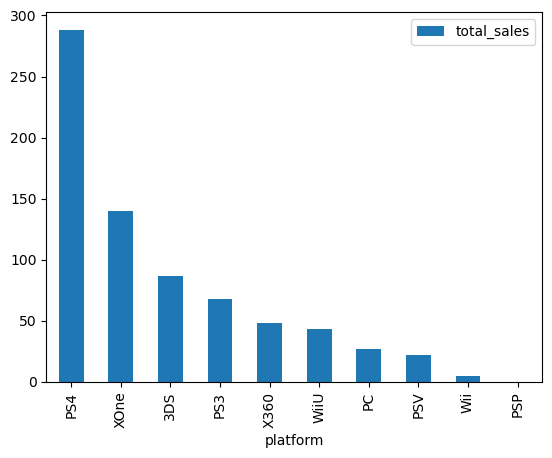

In [33]:
# посмотрим график зависимости продаж от типа платформ за актуальный период 2014-2016
platform_sales_top = games_slice.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values('total_sales', ascending=False).plot(kind='bar')

Из данного графика видно, что за актуальный период в топе по продажам такие платформы как PS4, XOne, 3DS


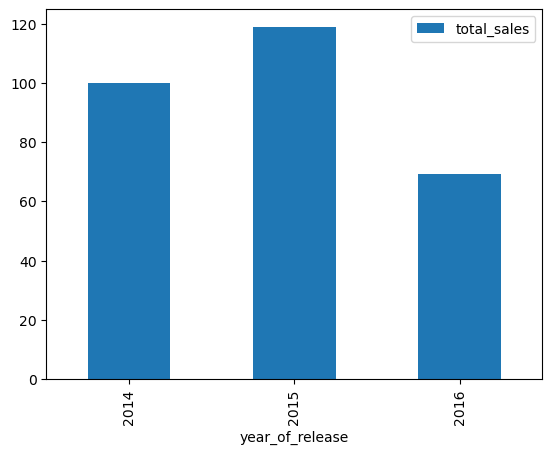

In [34]:
# построим распределение платформ по годам
games_slice.query('platform == "PS4"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar');

по платформе PS4 продажи находятся примерно на одном уровне - ее стабильно много покупают в течение предыдущих трех лет

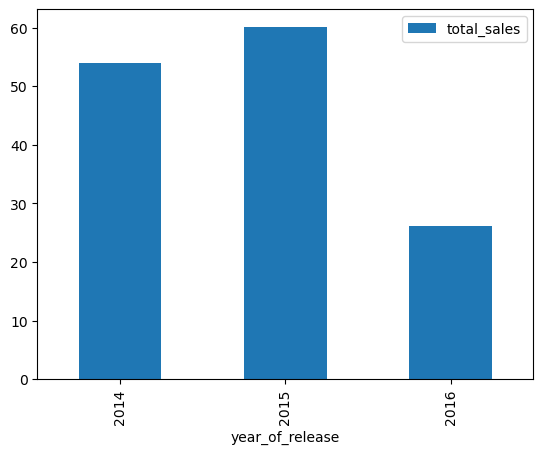

In [35]:
games_slice.query('platform == "XOne"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar');

На основе этого графика можно утверждать, что продаж раза в 2 меньше чем у PS4, но есть и схожий момент с консолью, описанной выше - примерно равные продажи за последний 3 года, учитывая то, что за 2016 неполные данные

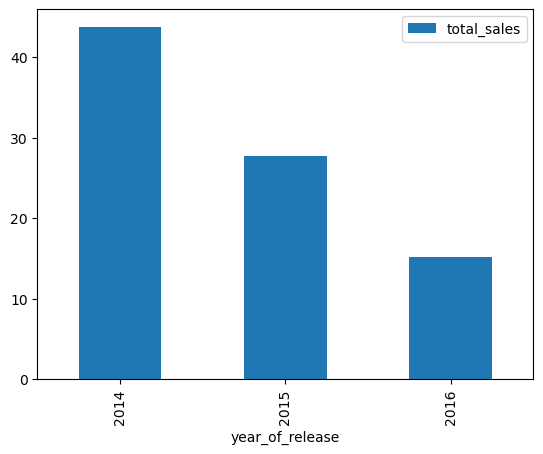

In [36]:
games_slice.query('platform == "3DS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar');

По этой платформе можно наблюдать ежегодный спад по 10 пунктов

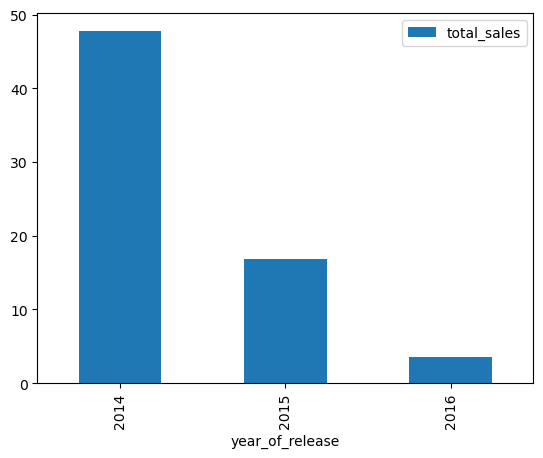

In [37]:
games_slice.query('platform == "PS3"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar');

По графику можно сказать, что в 2015 кол-во продаж резко снизилось относительно предыдущего 2014г., а в 2016г. продажи минимальны. Это объясняется фактом, что появилась более современная консоль той же серии PS4

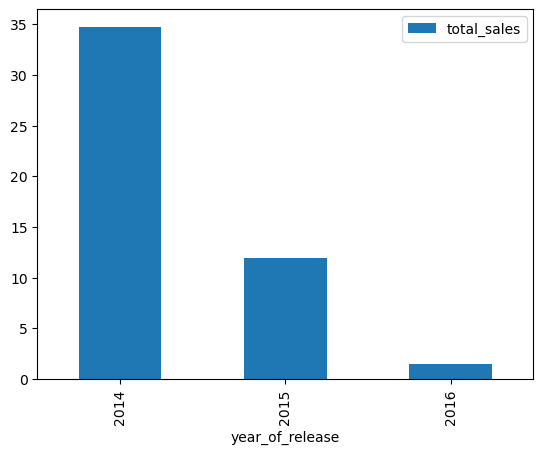

In [38]:
games_slice.query('platform == "X360"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar');

    Схожая ситуация и с этой платформой, в 2016 смысла не было ее выпускать, так как пришла новая обновленная версия

    По итогу анализа количества продаж платформ за актуальный период имеет смысл не учитывать платформы с минимальными продажами(PS3, X360, Wii, PSP) для дальнейшей работы с данными.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

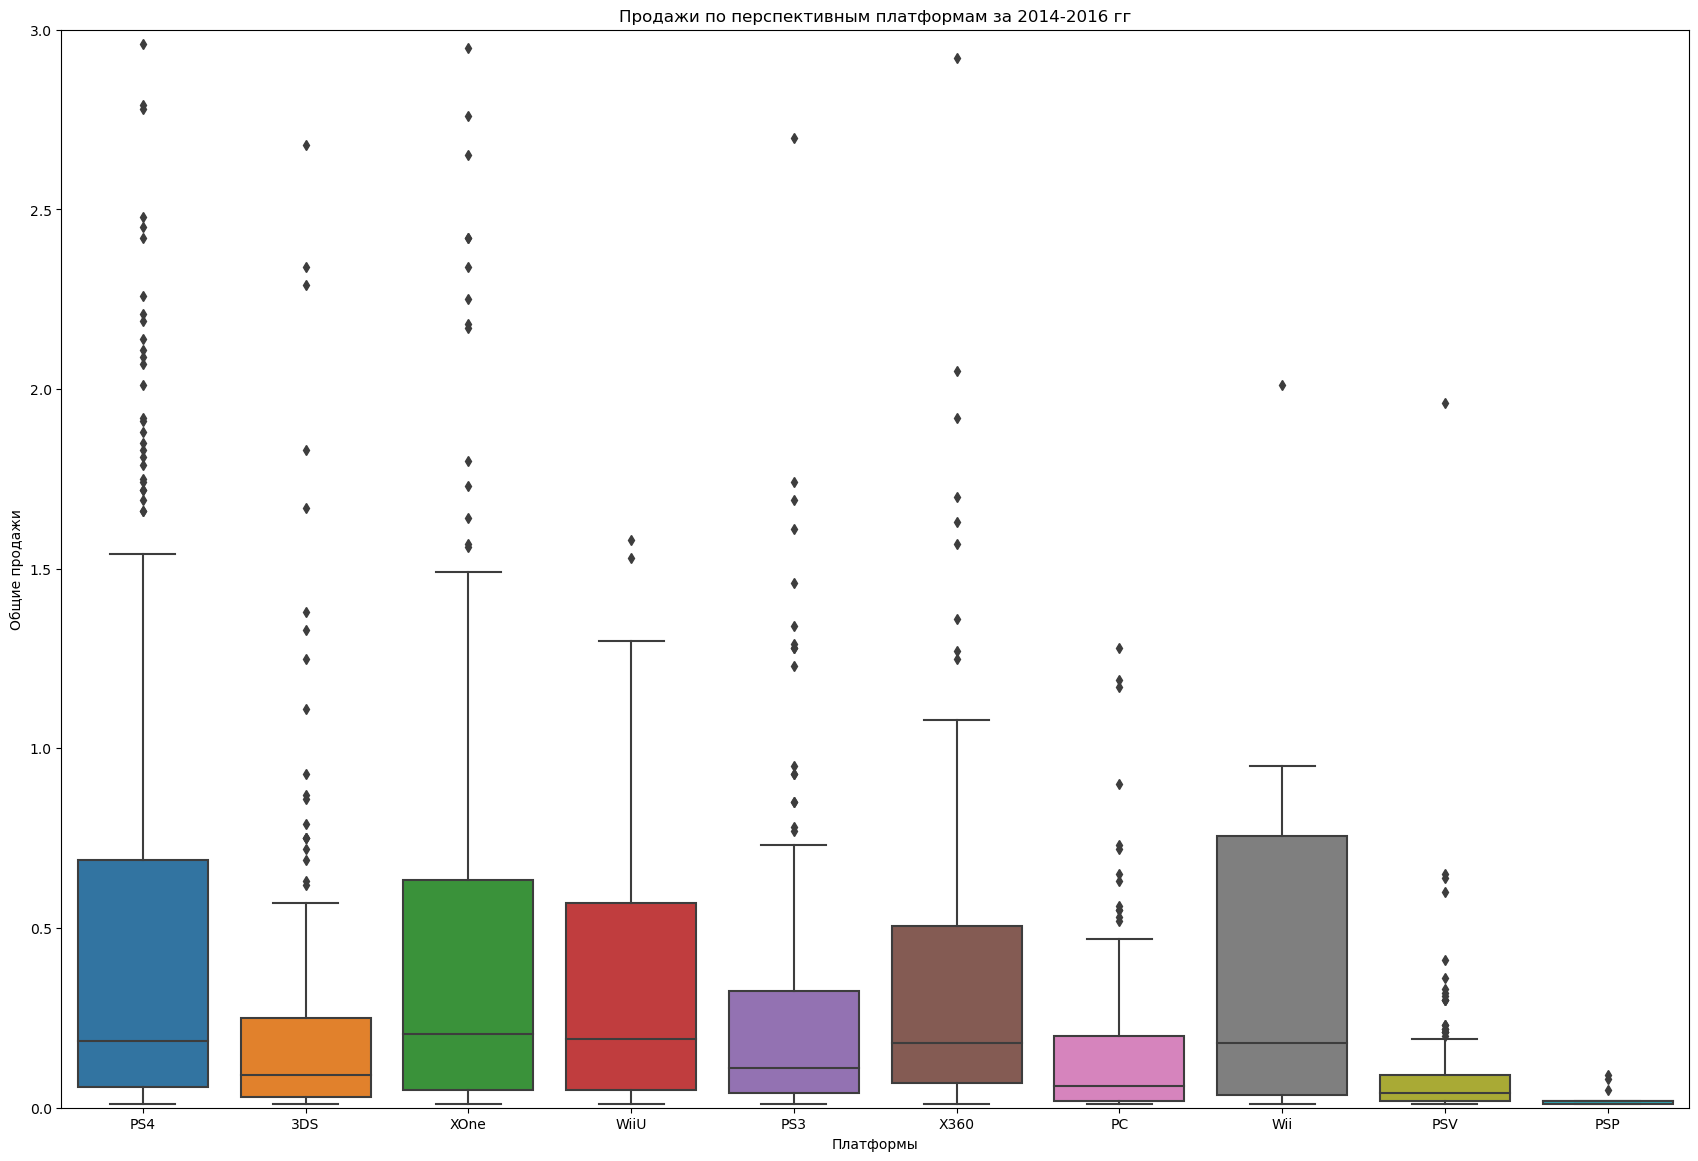

In [39]:
fig = plt.figure(figsize = (21,14))
sns.boxplot(data = games_slice, y = 'total_sales', x='platform').set(title = 'Продажи по перспективным платформам за 2014-2016 гг', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 3))
plt.show()

In [40]:
games_slice.pivot_table(index = 'platform', values = ['total_sales'],aggfunc = ['var', 'median', 'mean'])

,var,median,mean
,total_sales,total_sales,total_sales
platform,,,
3DS,1.412219,0.090,0.408868
PC,0.108477,0.060,0.179139
PS3,0.400764,0.110,0.311324
PS4,2.608124,0.185,0.766356
PSP,0.000769,0.020,0.027692
PSV,0.020048,0.040,0.075932
Wii,0.391189,0.180,0.460909
WiiU,1.349005,0.190,0.588767


<b>Итог:</b>
    Из графика «ящик с усами» можно увидеть, что практически по всем платформам существуют выбросы дальше третьих квартилей. Платформы PS4, WiiU и XOne имеют одинаковые медианные значения продаж (0.185, 0.190, 0.205), также примерно равны средние арифметические значения продаж (0.766356, 0.588767, 0.615614). Из этого следует, что большей популярностью пользуются, как и предполагалось -   платформы PS4, WiiU и XOne.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

              critic_score  total_sales
critic_score      1.000000     0.402661
total_sales       0.402661     1.000000
             user_score  total_sales
user_score     1.000000    -0.040132
total_sales   -0.040132     1.000000


array([[<Axes: xlabel='user_score', ylabel='user_score'>,
        <Axes: xlabel='total_sales', ylabel='user_score'>],
       [<Axes: xlabel='user_score', ylabel='total_sales'>,
        <Axes: xlabel='total_sales', ylabel='total_sales'>]], dtype=object)

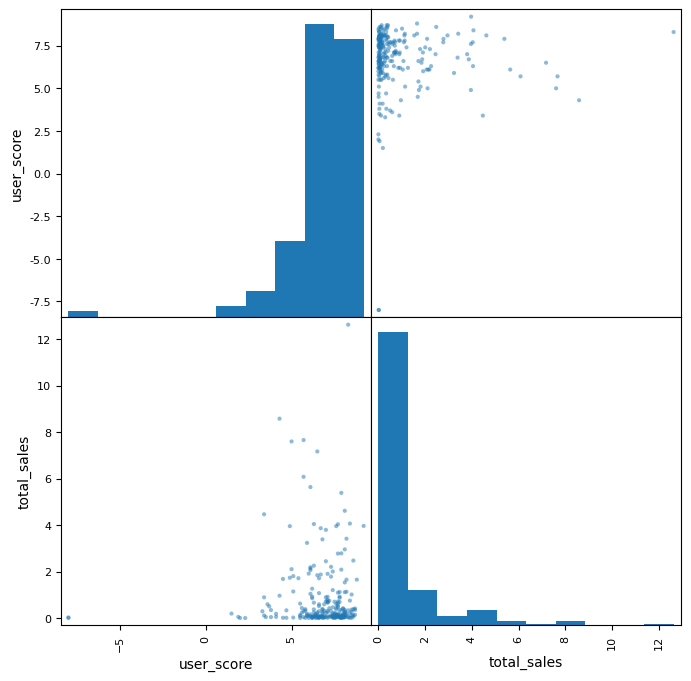

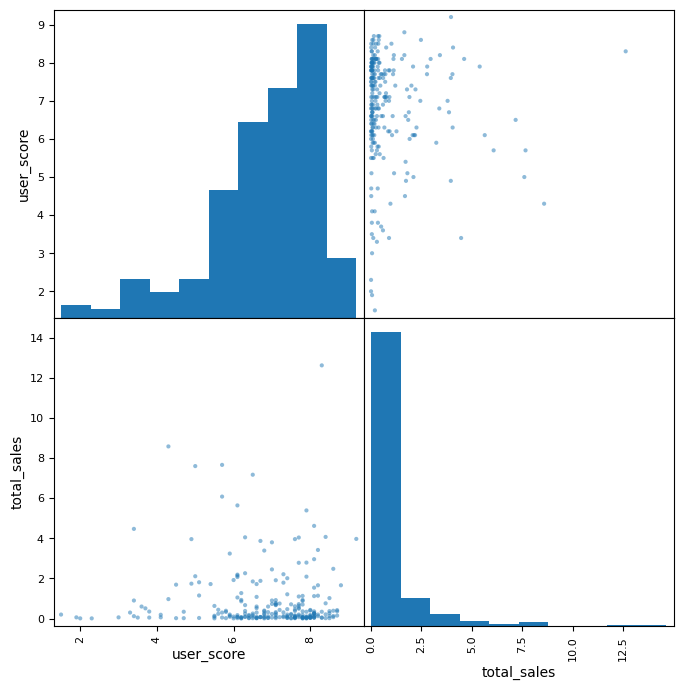

In [41]:
games_platform = games_slice.query('platform == "PS4"')
games_platform_critic = games_platform.query('critic_score != -8')
print(games_platform_critic[['critic_score', 'total_sales']] .corr())
pd.plotting.scatter_matrix(games_platform_critic[['user_score', 'total_sales']], figsize=(8,8))

games_platform_user = games_platform.query('user_score != -8')
print(games_platform_user [['user_score', 'total_sales']] .corr())
pd.plotting.scatter_matrix(games_platform_user [['user_score', 'total_sales']], figsize=(8,8))

In [42]:
print(len(games_platform[games_platform['user_score'] != -8]))
print(len(games_platform[games_platform['critic_score'] != -8]))
print(len(games_platform[(games_platform['critic_score'] != -8) & (games_platform['user_score'] != -8)]))

370
237
235


Оценка критиков для платформы PS4 имеет слабое влияние на продажи, а оценка же пользователей влияет очень слабо

              critic_score  total_sales
critic_score      1.000000     0.428677
total_sales       0.428677     1.000000
             user_score  total_sales
user_score     1.000000    -0.070384
total_sales   -0.070384     1.000000


array([[<Axes: xlabel='user_score', ylabel='user_score'>,
        <Axes: xlabel='total_sales', ylabel='user_score'>],
       [<Axes: xlabel='user_score', ylabel='total_sales'>,
        <Axes: xlabel='total_sales', ylabel='total_sales'>]], dtype=object)

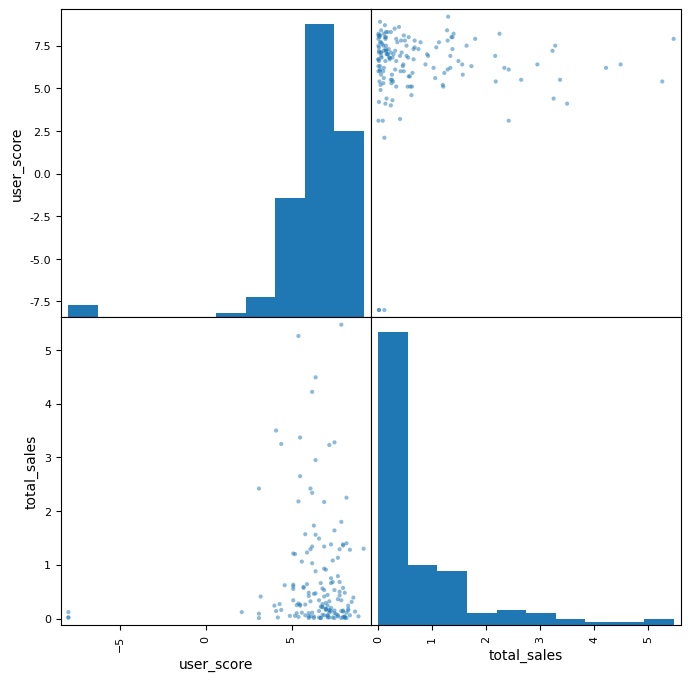

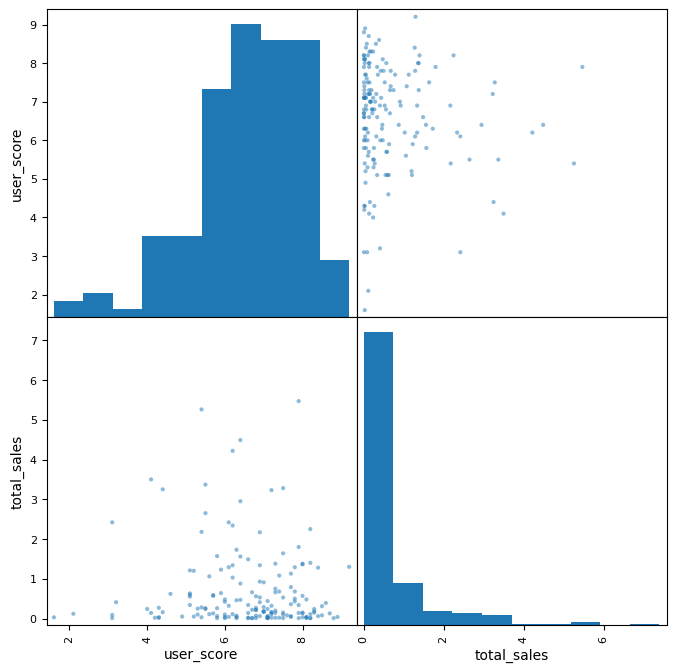

In [43]:
games_platform = games_slice.query('platform == "XOne"')
games_platform_critic = games_platform.query('critic_score != -8')
print(games_platform_critic[['critic_score', 'total_sales']] .corr())
pd.plotting.scatter_matrix(games_platform_critic[['user_score', 'total_sales']], figsize=(8,8))

games_platform_user = games_platform.query('user_score != -8')
print(games_platform_user [['user_score', 'total_sales']] .corr())
pd.plotting.scatter_matrix(games_platform_user [['user_score', 'total_sales']], figsize=(8,8))

Оценка критиков для платформы XOne имеет слабое влияние на продажи, а оценка же пользователей влияет очень слабо

              critic_score  total_sales
critic_score      1.000000     0.042665
total_sales       0.042665     1.000000
             user_score  total_sales
user_score     1.000000    -0.168455
total_sales   -0.168455     1.000000


array([[<Axes: xlabel='user_score', ylabel='user_score'>,
        <Axes: xlabel='total_sales', ylabel='user_score'>],
       [<Axes: xlabel='user_score', ylabel='total_sales'>,
        <Axes: xlabel='total_sales', ylabel='total_sales'>]], dtype=object)

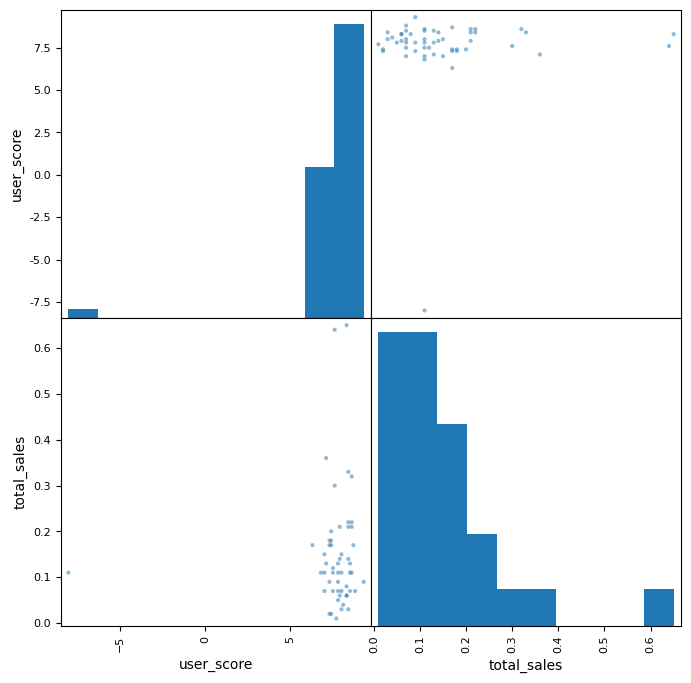

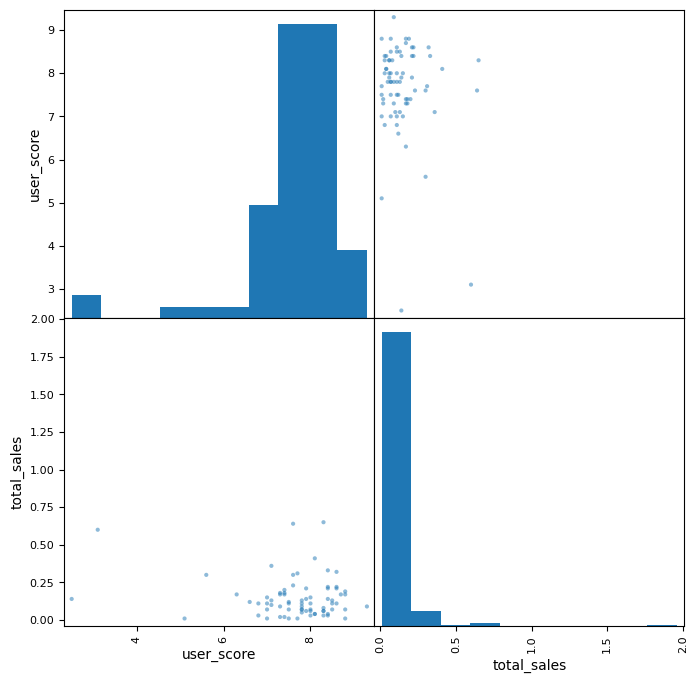

In [44]:
games_platform = games_slice.query('platform == "PSV"')
games_platform_critic = games_platform.query('critic_score != -8')
print(games_platform_critic[['critic_score', 'total_sales']] .corr())
pd.plotting.scatter_matrix(games_platform_critic[['user_score', 'total_sales']], figsize=(8,8))

games_platform_user = games_platform.query('user_score != -8')
print(games_platform_user [['user_score', 'total_sales']] .corr())
pd.plotting.scatter_matrix(games_platform_user [['user_score', 'total_sales']], figsize=(8,8))

Оценка критиков для платформы PSV имеет слабое влияние на продажи, а оценка же пользователей влияет очень слабо

              critic_score  total_sales
critic_score      1.000000     0.174634
total_sales       0.174634     1.000000
             user_score  total_sales
user_score     1.000000    -0.071597
total_sales   -0.071597     1.000000


array([[<Axes: xlabel='user_score', ylabel='user_score'>,
        <Axes: xlabel='total_sales', ylabel='user_score'>],
       [<Axes: xlabel='user_score', ylabel='total_sales'>,
        <Axes: xlabel='total_sales', ylabel='total_sales'>]], dtype=object)

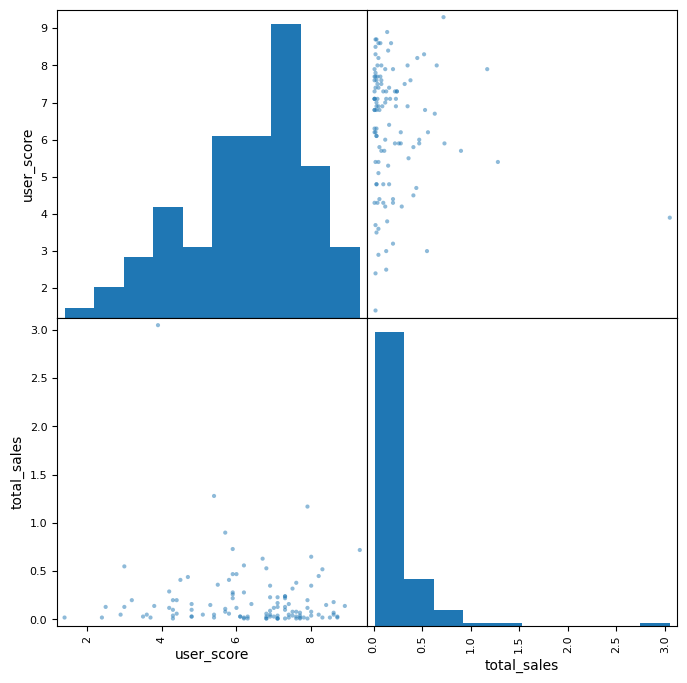

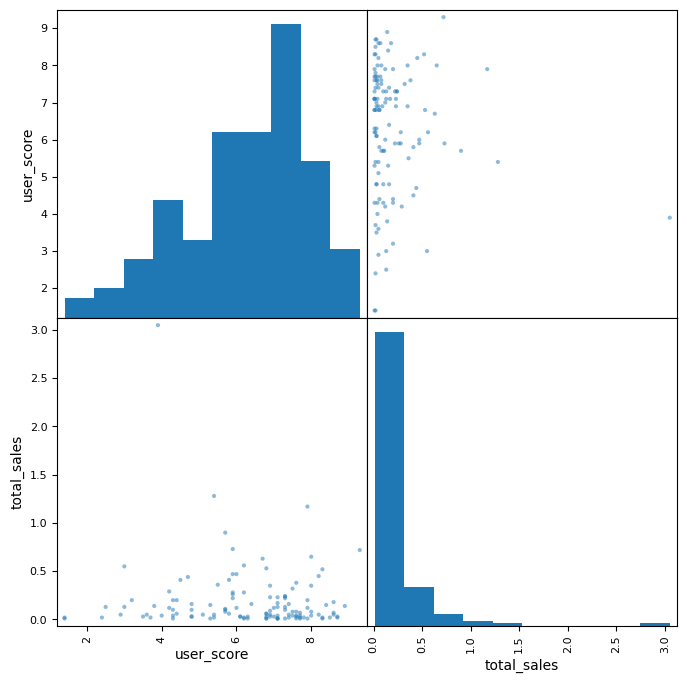

In [45]:
games_platform = games_slice.query('platform == "PC"')
games_platform_critic = games_platform.query('critic_score != -8')
print(games_platform_critic[['critic_score', 'total_sales']] .corr())
pd.plotting.scatter_matrix(games_platform_critic[['user_score', 'total_sales']], figsize=(8,8))

games_platform_user = games_platform.query('user_score != -8')
print(games_platform_user [['user_score', 'total_sales']] .corr())
pd.plotting.scatter_matrix(games_platform_user [['user_score', 'total_sales']], figsize=(8,8))

Оценка критиков для платформы PC имеет очень слабое влияние на продажи, а оценка же пользователей влияет очень слабо

              critic_score  total_sales
critic_score      1.000000     0.370201
total_sales       0.370201     1.000000
             user_score  total_sales
user_score     1.000000     0.407926
total_sales    0.407926     1.000000


array([[<Axes: xlabel='user_score', ylabel='user_score'>,
        <Axes: xlabel='total_sales', ylabel='user_score'>],
       [<Axes: xlabel='user_score', ylabel='total_sales'>,
        <Axes: xlabel='total_sales', ylabel='total_sales'>]], dtype=object)

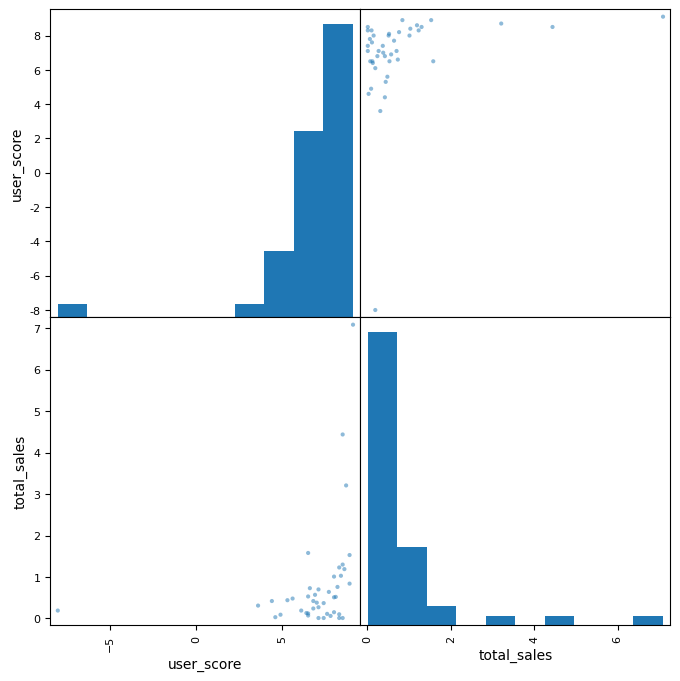

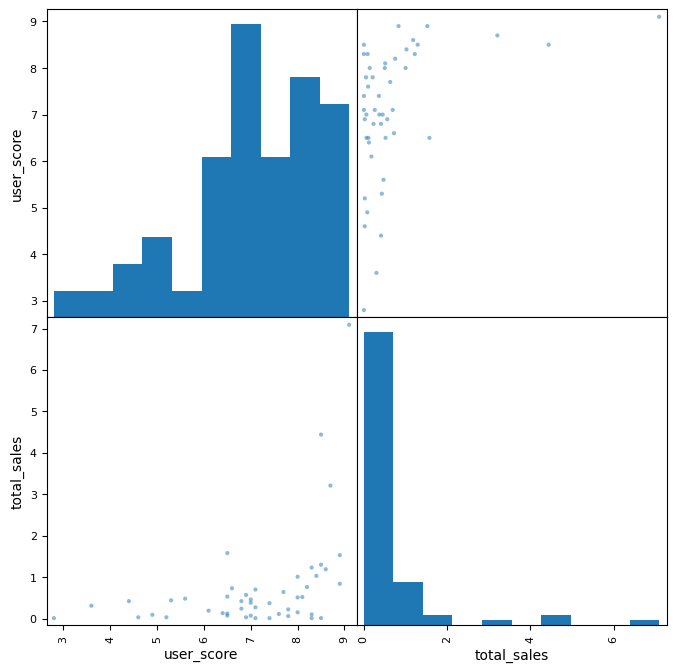

In [46]:
games_platform = games_slice.query('platform == "WiiU"')
games_platform_critic = games_platform.query('critic_score != -8')
print(games_platform_critic[['critic_score', 'total_sales']] .corr())
pd.plotting.scatter_matrix(games_platform_critic[['user_score', 'total_sales']], figsize=(8,8))

games_platform_user = games_platform.query('user_score != -8')
print(games_platform_user [['user_score', 'total_sales']] .corr())
pd.plotting.scatter_matrix(games_platform_user [['user_score', 'total_sales']], figsize=(8,8))

Оценка критиков для платформы WiiU имеет слабое влияние на продажи, а оценка же пользователей влияет слабо

<b>Подвывод:</b> 
    Из построенных диаграмм рассеяния и расчета коэффициента корреляции по каждой платформе можно заключить, что оценка критиков для топ 5 платформ влияет слабо на продажи и имеет очень слабое влияние на продажи - скорее всего, потому что ESRB - северо-американский рейтинг. Среди рассмотренных платформ выделяется WiiU, имея относительно других платформ высокий показатель 'user_score'. 

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Для оценки корреляции лучше пользоваться вот этой шкалой:</font>
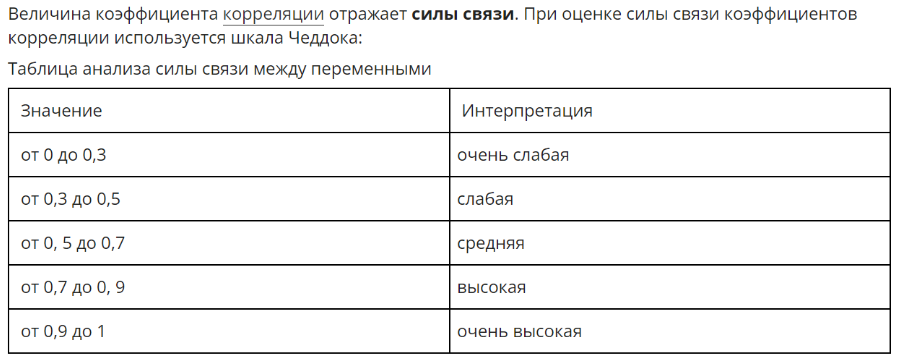

Для начала посмотрим на общее распределение игр по жанрам - выделяются ли жанры с высокими и низкими продажами

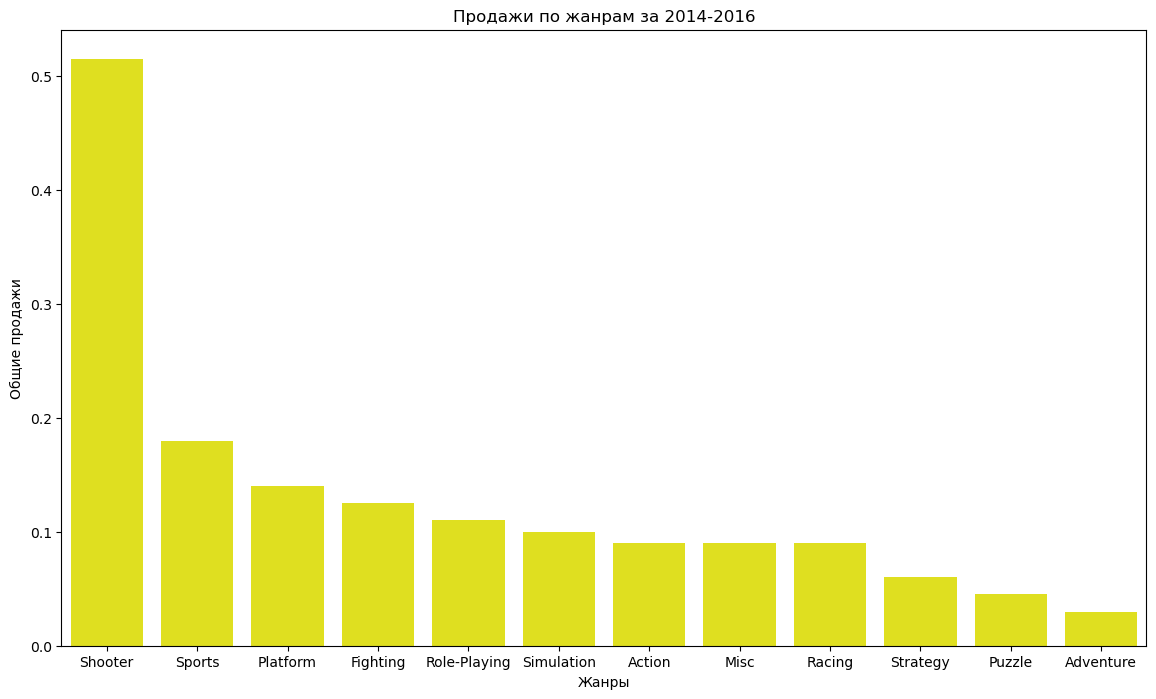

In [47]:
# Построим график распределения продаж по жанрам игр
plt.figure(figsize=(14, 8))
platform_sales_slice = games_slice.pivot_table(index='genre', values='total_sales', aggfunc='median').sort_values('total_sales', ascending=False)
(sns.barplot(data = platform_sales_slice, x = platform_sales_slice.index, y = 'total_sales', color = 'yellow')
    .set(title = 'Продажи по жанрам за 2014-2016', xlabel = 'Жанры', ylabel = 'Общие продажи'))
plt.show()


По графику видно, что наиболее популярными жанрами являются: Shooter - примечателен большой отрыв от всех остальных и далее идут в порядке убывания: Sports, Platform, Fighting, Role-Playing, Simulation, Action, Misc, Racing, Strategy, Puzzle, Adventure

<b>Шаг 4.</b> Составим портрет пользователя каждого региона

<b>Определим для пользователя каждого региона (NA, EU, JP):</b>
- Самые популярные платформы (топ-5). Опишем различия в долях продаж;
- Самые популярные жанры (топ-5). Поясним разницу;
- Выявим влияет ли рейтинг ESRB на продажи в отдельном регионе.

In [48]:
# сумма продаж в Северной Америке по платформам
na_plat = games_slice.groupby(['platform'])['na_sales'].agg(['sum'])
# сумма продаж в Европе по платформам
eu_plat = games_slice.groupby(['platform'])['eu_sales'].agg(['sum'])
# сумма продаж в Японии по платформам
jp_plat = games_slice.groupby(['platform'])['jp_sales'].agg(['sum'])

In [49]:
# объединяем все в один датасет
users_plat = pd.concat([na_plat, eu_plat, jp_plat], axis=1).reset_index()
users_plat.columns = ['platform', 'american_user', 'europe_user', 'japan_user']
users_plat = users_plat.sort_values(by='american_user', ascending=False)

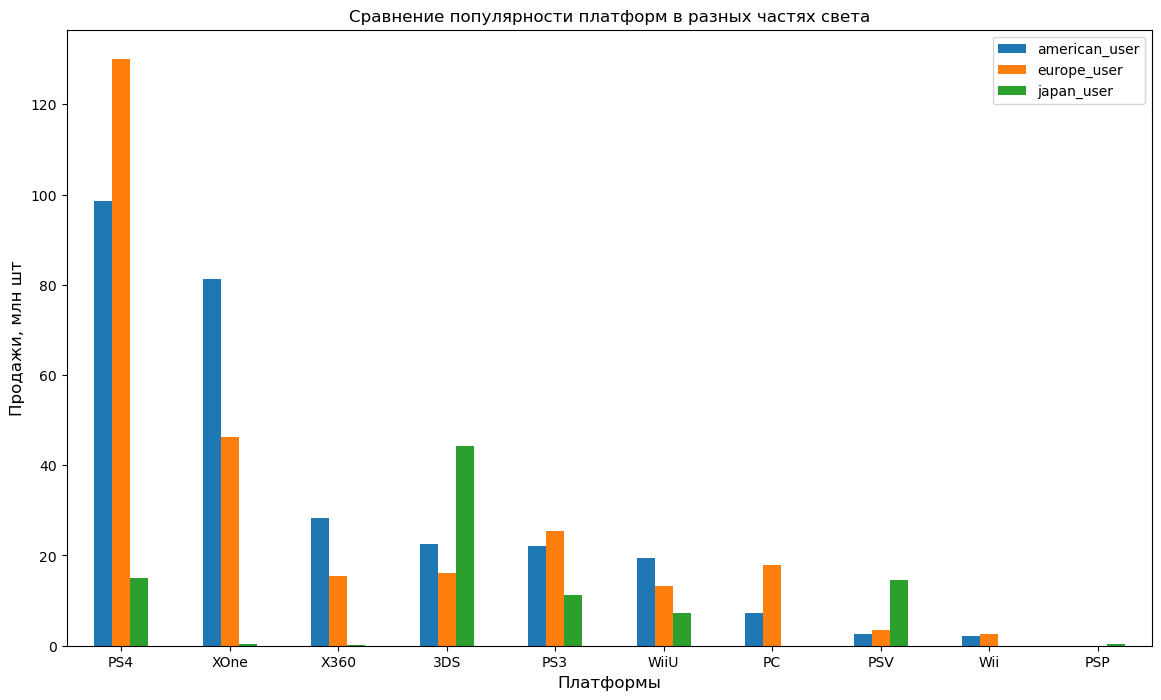

In [50]:
# посмотрим наглядно на данные по графику
users_plat.plot.bar(x="platform", rot=0, figsize =(14, 8))
plt.title('Сравнение популярности платформ в разных частях света', fontsize=12)
plt.xlabel('Платформы', fontsize=12)
plt.ylabel('Продажи, млн шт',fontsize=12)
plt.show()

<b>По графику очень четко все видно:</b>

- для жителей Северной Америки самыми популярными платформами являются PS4 (около 100 млн.шт) и XOne (около 80 млн.шт), наименее популярными платформами являются PC и PSV.
- для жителей Европы самыми популярными платформами также являются PS4 (более 120 млн.шт) и XOne (более 40 млн.шт), наименее популярной платформой является PSV.
- для жителей Японии самой популярной платформой является 3DS (более 40 млн.шт), платформы PS4 и PSV имеют примерно одинаковые кол-во продаж (немного менее 19 млн.шт), наименее популярными платформами являются WiiU, XOne и PC.

Выявим для пользователей каждого из регионов - <b>NA, EU, JP</b> - самые популярные жанры видеоигр

In [51]:
# сумма продаж в Северной Америке по жанрам
na_genre = games_slice.groupby(['genre'])['na_sales'].agg(['sum'])
# сумма продаж в Европе по жанрам
eu_genre = games_slice.groupby(['genre'])['eu_sales'].agg(['sum'])
# сумма продаж в Японии по жанрам
jp_genre = games_slice.groupby(['genre'])['jp_sales'].agg(['sum'])

In [52]:
# объединяем все в один датасет
users_genre = pd.concat([na_genre, eu_genre, jp_genre], axis=1).reset_index()
users_genre.columns = ['genre', 'american_user', 'europe_user', 'japan_user']
users_genre = users_genre.sort_values(by='genre', ascending=False)
users_genre.head()

,genre,american_user,europe_user,japan_user
11,Strategy,0.98,1.79,0.95
10,Sports,46.13,45.73,3.26
9,Simulation,2.63,7.30,2.31
8,Shooter,79.02,65.52,4.87
7,Role-Playing,33.47,28.17,31.16


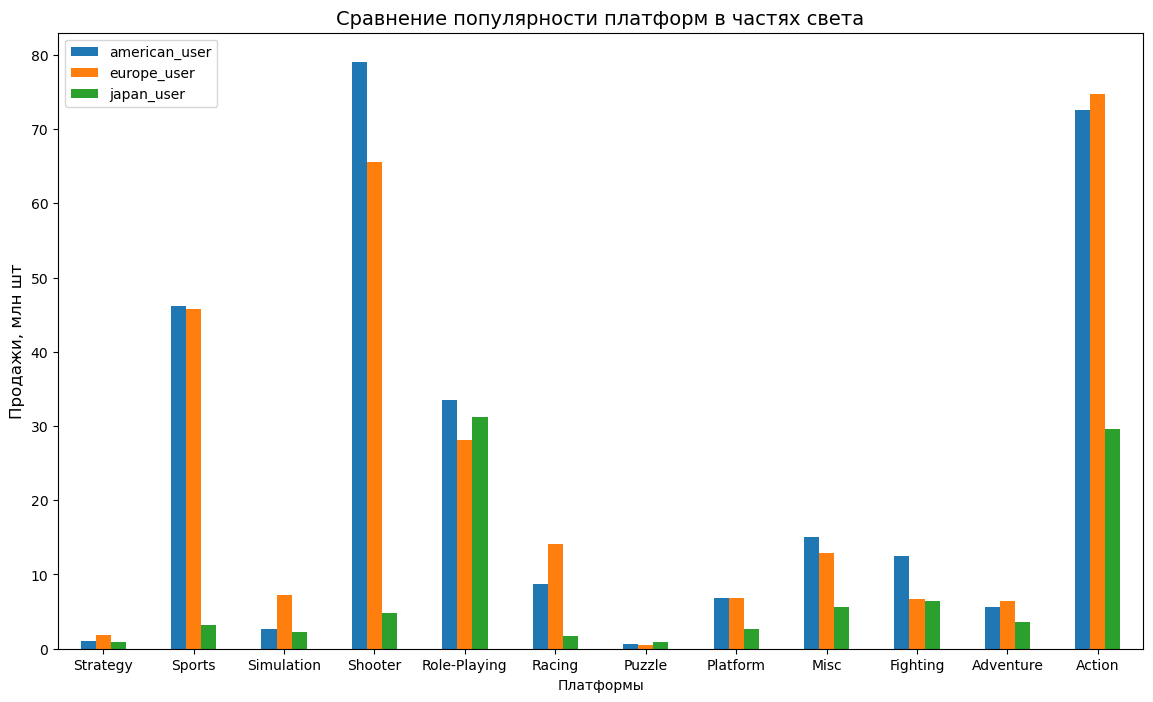

In [53]:
# посмотрим наглядно на данные по графику
users_genre.plot.bar(x="genre", rot=0, figsize =(14, 8))
plt.title('Сравнение популярности платформ в частях света', fontsize=14)
plt.xlabel('Платформы', fontsize=10)
plt.ylabel('Продажи, млн шт',fontsize=12)
plt.show()

<b>По графику очень четко видно:</b>

- для жителей Северной Америки самыми популярными жанрами являются Shooter (около 80 млн.шт) и Action (более 70 млн.шт), также в топ 3 входит и жанр Sports(более 40 млн.шт), наименее популярными жанрами являются Strategy и Puzzle.
- для жителей Европы самыми популярными жанрами также являются Shooter (около 70 млн.шт) и Action (более 70 млн.шт), также в топ 3 входит и жанр Sports(более 45 млн.шт), наименее популярными жанрами является Strategy и Puzzle.
- для жителей Японии самыми популярными жанрами являются Role-Playing(более 30 млн.шт) и Action (немногим менее 30 млн.шт), платформы PS4 и PSV имеют примерно одинаковые кол-во продаж (немного менее 19 млн.шт), наименее популярными жанрами также являются Strategy и Puzzle.

Рассмотрим влияние рейтинга ESRB на продажи в отдельном регионе

In [ ]:
# сумма продаж в Северной Америке по рейтингу
na_rate = games_slice.groupby(['rating'])['na_sales'].agg(['sum'])
# сумма продаж в Европе по рейтингу
eu_rate = games_slice.groupby(['rating'])['eu_sales'].agg(['sum'])
# сумма продаж в Японии по рейтингу
jp_rate = games_slice.groupby(['rating'])['jp_sales'].agg(['sum'])

In [ ]:
# объединяем все в один датасет
users_rate = pd.concat([na_rate, eu_rate, jp_rate], axis=1).reset_index()
users_rate.columns = ['genre', 'american_user', 'europe_user', 'japan_user']
users_rate = users_rate.sort_values(by='american_user', ascending=False)

In [ ]:
# посмотрим наглядно на данные по графику
users_rate.plot.bar(x="genre", rot=0, figsize =(14, 8))
plt.title('Сравнение популярности рейтинга  ESRB в разных частях света', fontsize=12)
plt.xlabel('Рейтинг  ESRB', fontsize=12)
plt.ylabel('Продажи, млн шт',fontsize=12)
plt.show()

<b>По графику очень четко видно:</b>

- для пользователей Америки и Европы наиболее популярные игры с рейтингом М (более 90 млн.шт.), далее идут игры с неопределенным рейтингом - Unknown (более 60 млн.шт.), не особо отстает и рейтинг Е показывая практически идентичные результаты(более 50 млн.шт.), Т и Е10+ - уже находятся за топ 3;
- для пользователей Японии картина отличается кардинально и влияния рейтингов видеоигр на продажи. Самыми популярными являются видеоигры с рейтингом Unknown (около 60 млн.шт.), затем идут видеоигры с рейтингом в последовательности от большего к меньшему все имея продаж менее 20 млн.шт. - Т, Е, М и Е10+.

<b>Подвывод:</b>
    На данном шаге проведены исследования для определения портрета пользователя в каждом регоине. Можно выделить, что большей популярностью у пользователей Америки и Европы примерно в равной степени являются PS4 и XOne, любимые жанры - Shooter и Action, игры с рейтингом М и Unknown. В связи с многочисленностью пользователей в данных регионах бизнесу рекомендуется повышенное внимание сначала стоит обратить на вышеуказанные платформы и жанры игр. Предпочтения пользователей из Японии кардинально отличаются, самой популярной платформой являются 3DS, любимые жанры - Role-Playing и Action и игры с рейтингом Unknown.

<b>Шаг 5.</b> Проверим гипотезы:
Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

H_0: Пользовательский рейтинг (user_score) платформы "XOne" = пользовательский  рейтинг (user_score) платформы "PC"`
<p>H_a: Пользовательский рейтинг (user_score) платформы "XOne" ≠ пользовательский рейтинг (user_score) платформы "PC"`</p>

In [59]:
# в начале нужно удалить значения-заглушки
games_slice[games_slice['user_score'] != -8]

x_one = games_slice.query('platform == "XOne"')['user_score']
pc = games_slice.query('platform == "PC"')['user_score']

results = st.ttest_ind(x_one, pc, nan_policy='omit')

alpha = .05
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8985788656318074
Не получилось отвергнуть нулевую гипотезу


В итоге принимаем альтернативную гипотезу, p-значение оказалось достаточно малым для обратного, что говорит о предположение об отсутствии разницы между cредними пользовательскими рейтингами жанров Action и Sports.

H_0: Среднепользовательский рейтинг (user_score) жанра 'Action' и среднепользовательский рейтинг (user_score) жанра "Sports" одинаковы<br
<p> H_a: Среднепользовательский рейтинг (user_score) жанра 'Action' и среднепользовательский рейтинг (user_score) жанра "Sports" разные </p>

In [61]:
Action = games_slice[(games_slice['genre'] == 'Action') &  (games_slice['user_score'] > 0)]['user_score']
Sports = games_slice[(games_slice['genre'] == 'Sports') &  (games_slice['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинг жанра Action:', Action.mean())
print('Средний пользовательский рейтинг жанра Sports', Sports.mean())

Средний пользовательский рейтинг жанра Action: 6.760606060606061
Средний пользовательский рейтинг жанра Sports 5.2251968503937


In [62]:
#проверяем гипотезу
alpha = .05

results = st.ttest_ind(Action, Sports, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


На имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.

<b>Шаг 6.</b> Напишем общий вывод

<b>ВЫВОД:</b>
- Перед началом анализа нужно было подготовить данные, чтобы с ними можно было работать, что мы и сделали - получилось преобразовать данные в датасете для дальнейшего использования - проработали пропуски:  в каких-то случаях строки были удалены за ненадобностью, в других пропуски - заменены на значение -8.<br>
- Приступив к анализу, мы первым делом посмотрели, как менялись продажи по платформам. Выбрали платформы с наибольшими суммарными продажами и построили распределение по годам. <br>
- Оказалось, что начиная платформы с наибольшими суммарными продажами: PS2, X360, PS3, Wii, DS, PS. Эти 6 платформ очевидно имеют высокие продажи относительно всех остальных.<br>
- Нашли актуальный период - около 3 лет до 2017 - его следует брать для формирования прогноза на 2017, так как эта информация и является более актуальной и будет влиять существенным образом.<br>
- По итогу анализа количества продаж платформ за актуальный период имеет смысл не учитывать платформы с минимальными продажами(PS3, X360, Wii, PSP) для дальнейшей работы с данными.<br>
- Построили «ящик с усами» и по нему выяснили, что практически по всем платформам существуют выбросы дальше третьих квартилей. Платформы PS4, WiiU и XOne имеют одинаковые медианные значения продаж (0.185, 0.190, 0.205), также примерно равны средние арифметические значения продаж (0.766356, 0.588767, 0.615614). Из этого следует, что большей популярностью пользуются, как и предполагалось - платформы PS4, WiiU и XOne.<br>
- Посмотрели, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Из построенных диаграмм рассеяния и расчета коэффициента корреляции по каждой платформе можно было бы увидеть взаимосвязь, но оценки критиков для всех платформ практически не влияют или же имеют очень слабое влияние на продажи. Очевидно, что оценки пользователей имеют слабое влияние на продажи и не влияют совсем.<br>
- Далее выяснили, что наиболее популярными жанрами являются: Shooter - примечателен большой отрыв от всех остальных и далее идут в порядке убывания: Sports, Platform, Fighting, Role-Playing, Simulation, Action, Misc, Racing, Strategy, Puzzle, Adventure.<br>
- Провели исследования для определения портрета пользователя в каждом регоине. Можно выделить, что большей популярностью у пользователей Америки и Европы примерно в равной степени являются PS4 и XOne, любимые жанры - Shooter и Action, игры с рейтингом М и Unknown. В связи с многочисленностью пользователей в данных регионах бизнесу рекомендуется повышенное внимание сначала стоит обратить на вышеуказанные платформы и жанры игр. Предпочтения пользователей из Японии кардинально отличаются, самой популярной платформой являются 3DS, любимые жанры - Role-Playing и Action и игры с рейтингом Unknown.
- В конце аналитической работы проверили гипотезы:<br>
Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.<br>
- По итогу приняли альтернативную гипотезу: на имеющихся данных, на уровне значимости 5% были основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.
   
   
   